# Evaluating DeepLiftSHAP

## Imports and Setup

In [1]:
import os
import platform
from pathlib import Path

# for when on NCC to be able to import local packages
os.chdir(os.path.expanduser("~/l3_project"))
Path.cwd()

PosixPath('/home2/jgcw74/l3_project')

In [2]:
import helpers
import dataset_processing.eurosat

/home2/jgcw74/l3_project/helpers/ml.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [33]:
import copy

from captum.attr import DeepLiftShap
import shap

import numpy as np
import matplotlib.pyplot as plt
import einops
from tqdm.autonotebook import tqdm

import torch
import torch.nn as nn
import torchvision.transforms.v2 as transforms
from safetensors.torch import load_model

In [4]:
print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

Using PyTorch 2.5.1 on Linux
Found NVIDIA A100 80GB PCIe to use as a cuda device.
Using cuda as torch device.


In [5]:
np_rng = np.random.default_rng(42)
_ = torch.manual_seed(42)

# EuroSAT (RGB) Dataset

In [6]:
base_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=False),  # scaling handles by normalise below
    dataset_processing.core.RSNormaliseTransform(0, 2750),
    # normalise to [0, 1] (based on maximums used in original paper)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True),  # shift to mean 0 and std 1

    # scale as expected by ResNet (see https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights)
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
])
wrapped_base_transforms = dataset_processing.core.tensor_dict_transform_wrapper(base_transforms)

eurosat_val_ds = dataset_processing.eurosat.get_dataset(
    "val", bands=("B04", "B03", "B02"),  # RGB bands
    transforms=wrapped_base_transforms, download=False
)

print(f"There are {len(eurosat_val_ds)} validation samples.")
print("Image dimensions and label:", eurosat_val_ds[0]["image"].size(), eurosat_val_ds[0]["label"])

There are 5400 validation samples.
Image dimensions and label: torch.Size([3, 224, 224]) tensor(0)


In [7]:
val_dataloader = torch.utils.data.DataLoader(
    eurosat_val_ds, batch_size=32, num_workers=4, shuffle=False, drop_last=False
)
validation_iterator = iter(dataset_processing.core.cycle(val_dataloader))

In [8]:
def show_image(img: torch.Tensor):
    if img.min() < 0:
        img = (img + 1) / 2  # un-normalise
    img = np.transpose(img.cpu(), (1, 2, 0))  # move colour channel to end
    plt.imshow(img)
    plt.axis("off")

## ResNet 50

### Load Model

In [9]:
checkpoints_path = Path.cwd() / 'checkpoints'
assert checkpoints_path.exists()

In [10]:
all_resnet50_saved = list(checkpoints_path.glob('./resnet50/*.st'))
# print(all_resnet50_saved)
latest_resnet50_path = max(all_resnet50_saved, key=os.path.getctime)
latest_resnet50_path

PosixPath('/home2/jgcw74/l3_project/checkpoints/resnet50/FineTunedResNet50_final_ft_weights(0.989).st')

In [41]:
resnet50 = helpers.models.FineTunedResNet50(num_classes=len(eurosat_val_ds.classes)).to(device)

In [42]:
print('Missing/Unexpected keys:', load_model(resnet50, latest_resnet50_path))

Missing/Unexpected keys: (set(), [])


#### Confirm model accuracy

In [13]:
check_acc = False
if check_acc:
    _, acc = helpers.ml.validation_step(
        resnet50, nn.CrossEntropyLoss(), validation_iterator, len(val_dataloader)
    )
    assert acc > 0.98
    print("Validation accuracy", acc)

### Select images to explain

In [14]:
idxs_to_explain = np_rng.integers(0, len(eurosat_val_ds), 5)
imgs_to_explain = torch.stack([eurosat_val_ds[i]["image"] for i in idxs_to_explain]).to(device)
true_labels = [eurosat_val_ds[i]["label"] for i in idxs_to_explain]

blurred_imgs = transforms.functional.gaussian_blur_image(imgs_to_explain, kernel_size=21, sigma=10)
black_imgs = torch.zeros_like(imgs_to_explain) - 1
# Black background as in https://dl.acm.org/doi/abs/10.1145/3331184.3331312
# Blurred as in https://www.sciencedirect.com/science/article/pii/S0303243421002270

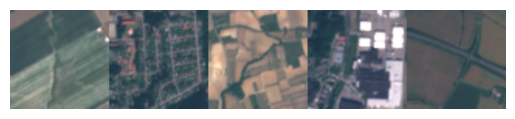

In [15]:
show_image(einops.rearrange(imgs_to_explain, "(b1 b2) c h w -> c (b1 h) (b2 w)", b2=len(idxs_to_explain)))

[tensor(0), tensor(7), tensor(6), tensor(4), tensor(3)]


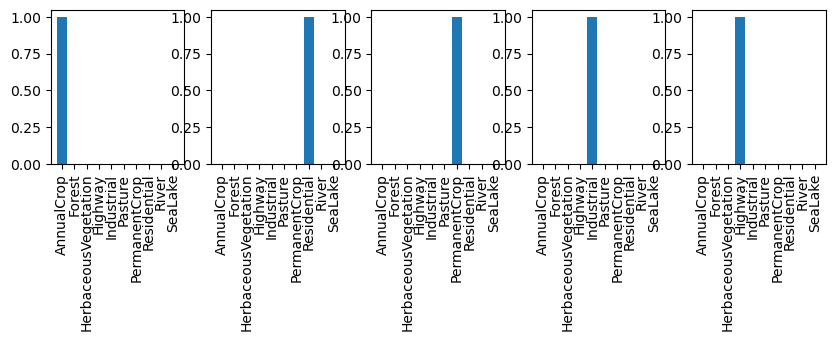

In [16]:
preds = resnet50(imgs_to_explain)
preds = torch.softmax(preds, dim=-1).cpu().detach().numpy()
_, axs = plt.subplots(1, len(idxs_to_explain), figsize=(2 * len(idxs_to_explain), 2))
for i in range(len(idxs_to_explain)):
    ax: plt.Axes = axs[i]
    ax.bar(eurosat_val_ds.classes, preds[i])
    # rotate x ticks for axis
    ax.tick_params(axis='x', rotation=90)
print(true_labels)

In [17]:
random_bg_imgs = torch.stack([eurosat_val_ds[i]["image"] for i in np_rng.integers(0, len(eurosat_val_ds), 100)]).to(
    device)

In [18]:
random_blurred_bg_imgs = transforms.functional.gaussian_blur_image(
    random_bg_imgs, kernel_size=15, sigma=10
).to(device)

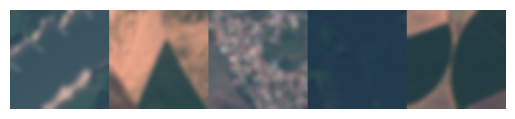

In [19]:
show_image(einops.rearrange(random_blurred_bg_imgs[:5], "(b1 b2) c h w -> c (b1 h) (b2 w)", b2=len(idxs_to_explain)))

### Run SHAP

#### Captum DeepLiftShap

In [20]:
deep_shap_explainer = DeepLiftShap(resnet50, multiply_by_inputs=True)  # True for global attribution

In [21]:
captum_shap_vals = torch.zeros(0).to(device)
for i in tqdm(range(len(eurosat_val_ds.classes))):
    shap_values_for_ith_label = deep_shap_explainer.attribute(
        imgs_to_explain, blurred_imgs,
        target=torch.tensor(i).to(device)
    ).detach()
    captum_shap_vals = torch.cat(
        (captum_shap_vals, shap_values_for_ith_label.unsqueeze(0)),
        dim=0
    ) if captum_shap_vals.size else shap_values_for_ith_label.unsqueeze(0)
captum_shap_vals.size()

  0%|          | 0/10 [00:00<?, ?it/s]

/home2/jgcw74/miniconda3/envs/sat_project/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


torch.Size([10, 5, 3, 224, 224])

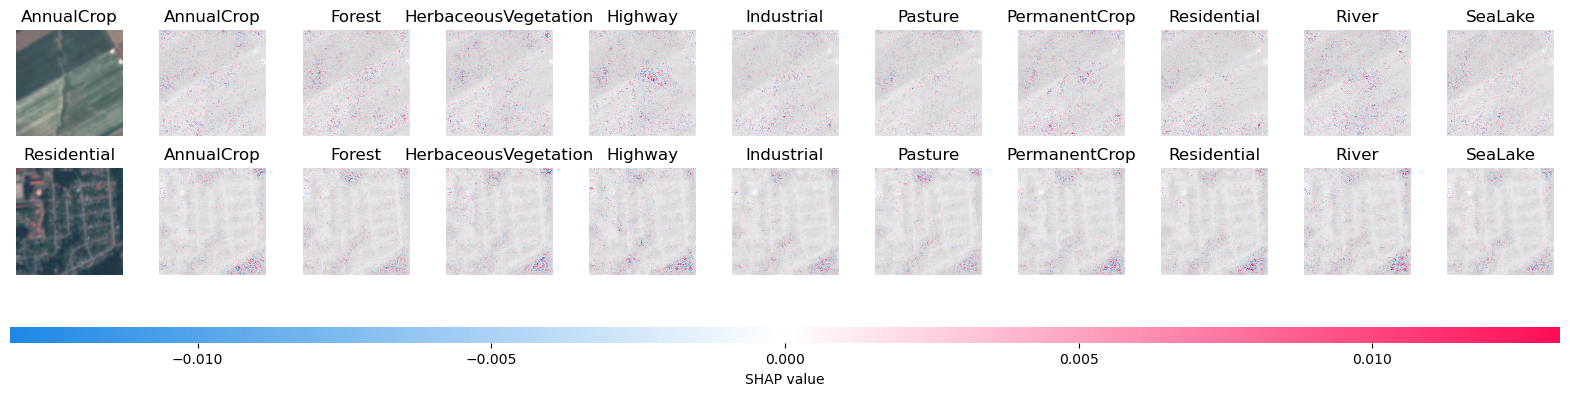

In [22]:
n = 2
shap.image_plot(
    list(einops.rearrange(captum_shap_vals[:, :n], "l b c h w -> l b h w c").cpu().numpy()),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
    hspace=0.3,
)

##### Pooled SHAP values

In [23]:
pool_size = 16
pooled_captum_shap_vals = (pool_size ** 2) * nn.AvgPool2d(kernel_size=pool_size, stride=pool_size)(
    captum_shap_vals.flatten(0, 1)
).repeat_interleave(pool_size, dim=-2).repeat_interleave(pool_size, dim=-1)
pooled_captum_shap_vals = torch.unflatten(pooled_captum_shap_vals, 0, (len(eurosat_val_ds.classes), -1))

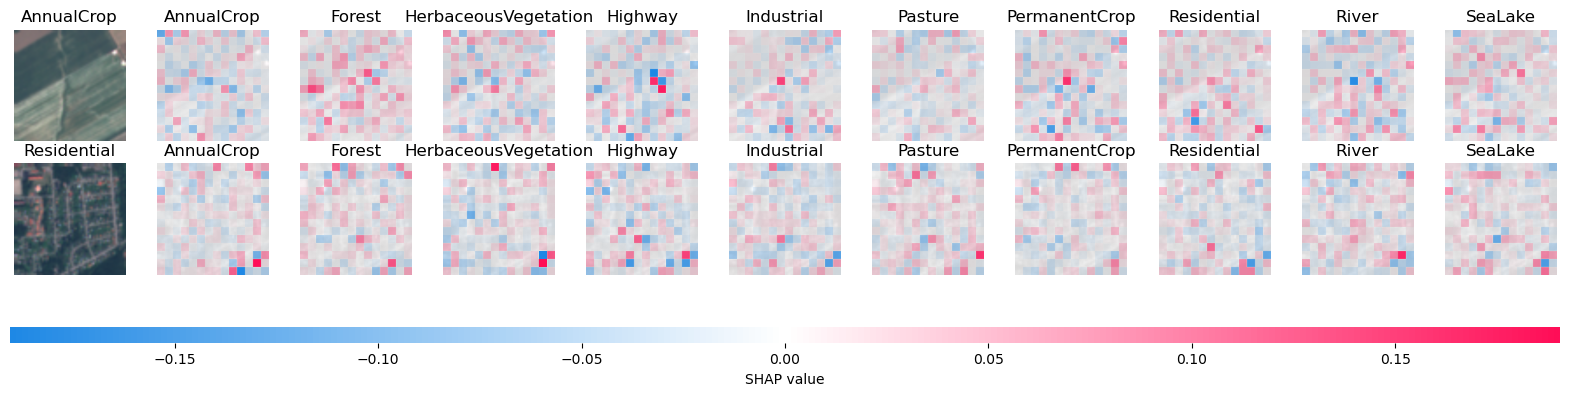

In [24]:
n = 2
shap.image_plot(
    list(einops.rearrange(pooled_captum_shap_vals[:, :n], "l b c h w -> l b h w c").cpu().numpy()),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
)

  0%|          | 0/10 [00:00<?, ?it/s]

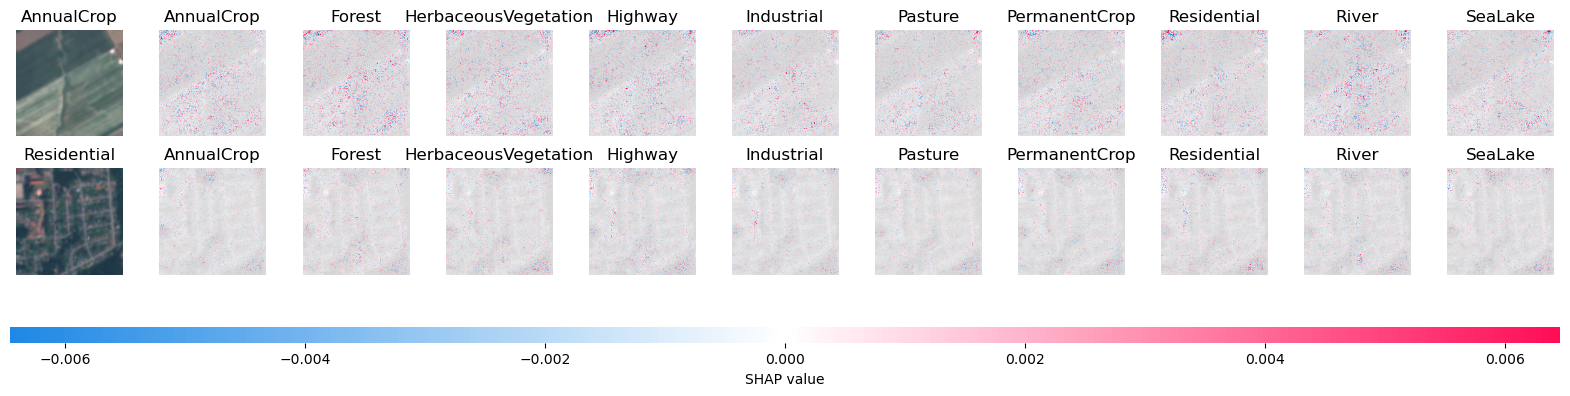

In [25]:
captum_blur_shap_vals = torch.zeros(0).to(device)
for i in tqdm(range(len(eurosat_val_ds.classes))):
    shap_values_for_ith_label = deep_shap_explainer.attribute(
        imgs_to_explain, random_bg_imgs[:25],  # uses a HUGE amount of memory (50GB for 25 imgs) so limit num samples
        target=torch.tensor(i).to(device)
    ).detach()
    captum_blur_shap_vals = torch.cat(
        (captum_blur_shap_vals, shap_values_for_ith_label.unsqueeze(0)),
        dim=0
    ) if captum_blur_shap_vals.size else shap_values_for_ith_label.unsqueeze(0)
captum_blur_shap_vals.size()
n = 2
shap.image_plot(
    list(einops.rearrange(captum_blur_shap_vals[:, :n], "l b c h w -> l b h w c").cpu().numpy()),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
    hspace=0.3,
)

#### Original SHAP library

In [26]:
def predict_fn(np_imgs: np.ndarray):
    model_input_img = einops.rearrange(torch.Tensor(np_imgs * 2) - 1, "b h w c -> b c h w").to(device)
    model_output = resnet50(model_input_img)
    # softmax_output = torch.softmax(model_output, dim=-1)
    return model_output.cpu().detach().numpy()

In [27]:
np01_imgs_to_explain = einops.rearrange((imgs_to_explain + 1) / 2, "b c h w -> b h w c").cpu().numpy()

##### Partition Explainer

Following regime in https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html

In [28]:
blur_masker = shap.maskers.Image("blur(128,128)", np01_imgs_to_explain[0].shape)
partition_explainer = shap.PartitionExplainer(predict_fn, blur_masker, output_names=eurosat_val_ds.classes)

In [29]:
partition_shap_vals = partition_explainer(
    np01_imgs_to_explain,
    max_evals=10000,
    batch_size=32,
    outputs=shap.Explanation.argsort.flip,  # order from most confident prediction (left) to lowest
)

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [01:11<00:34, 17.06s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [01:46<00:24, 24.29s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [02:21<00:00, 28.24s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [02:55, 35.14s/it]                       


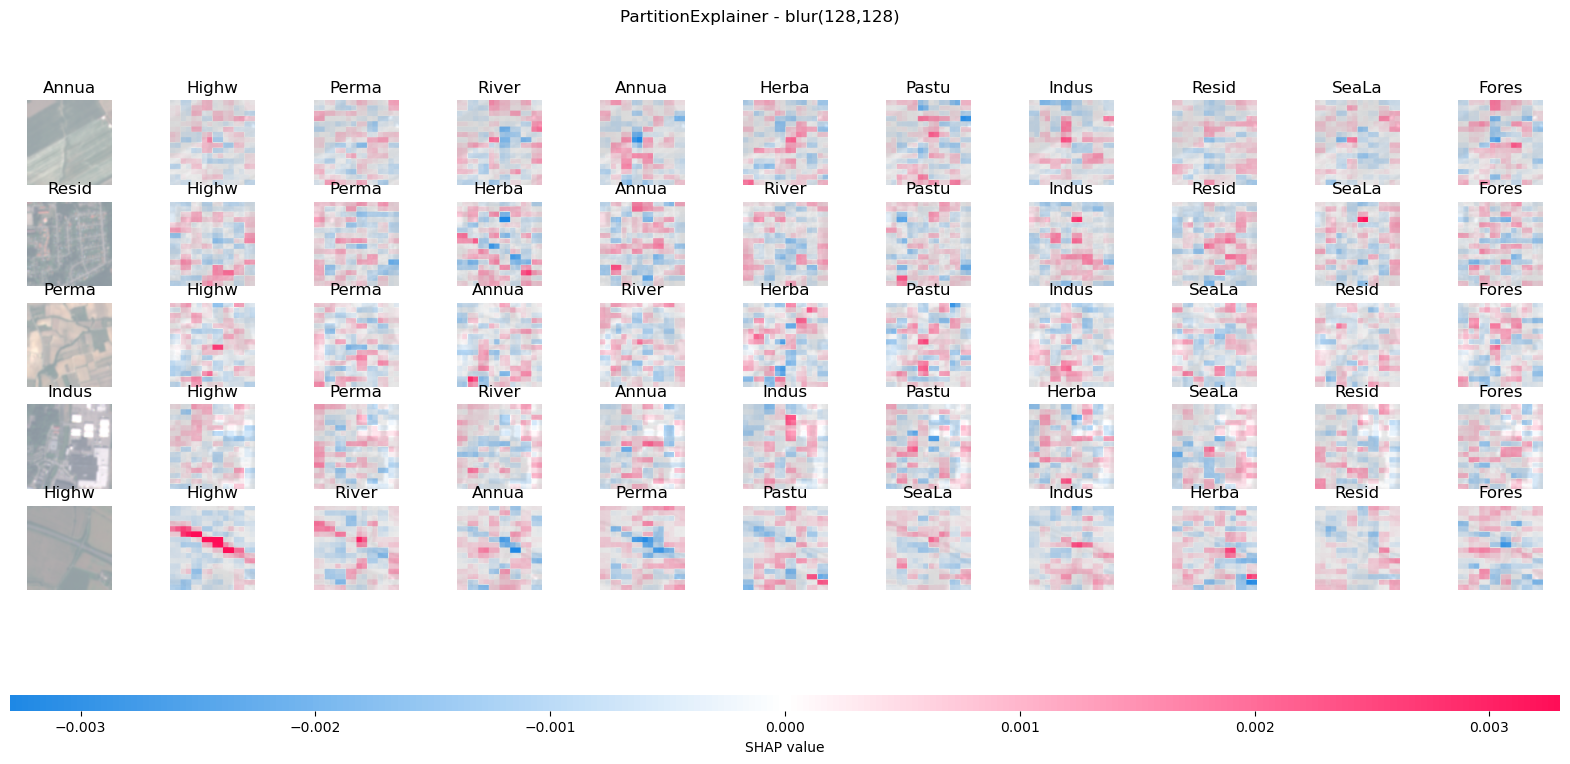

In [30]:
shap.image_plot(
    shap_values=[val for val in np.moveaxis(partition_shap_vals.values, -1, 0)],
    pixel_values=((partition_shap_vals.data + 1) / 2),
    labels=np.vectorize(lambda x: x[:5])(partition_shap_vals.output_names),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels],
    show=False,
)
_ = plt.gcf().suptitle(f"{partition_explainer.__class__.__name__} - {blur_masker.mask_value}")

###### Using 0 masker

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:54, 27.45s/it]               


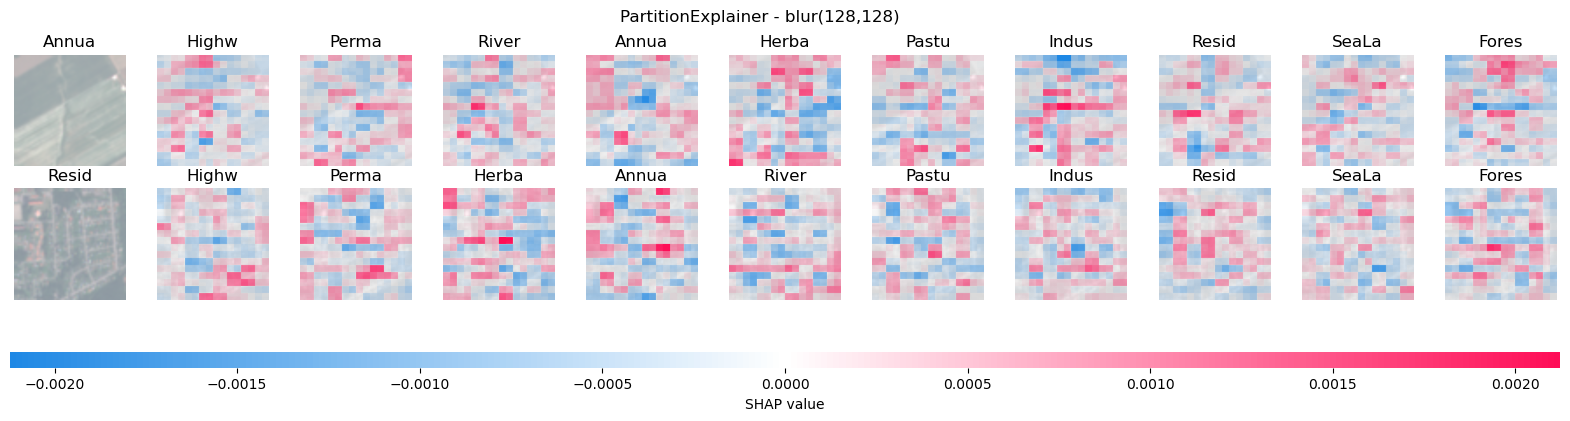

In [31]:
masker = shap.maskers.Image(0, np01_imgs_to_explain[0].shape)  # fill with zeros rather than blurring
partition0_explainer = shap.PartitionExplainer(predict_fn, masker, output_names=eurosat_val_ds.classes)
partition0_shap_vals = partition0_explainer(
    np01_imgs_to_explain[:2],
    max_evals=10000,
    batch_size=32,
    outputs=shap.Explanation.argsort.flip,  # order from most confident prediction (left) to lowest
)
shap.image_plot(
    shap_values=[val for val in np.moveaxis(partition0_shap_vals.values, -1, 0)],
    pixel_values=((partition0_shap_vals.data + 1) / 2),
    labels=np.vectorize(lambda x: x[:5])(partition0_shap_vals.output_names),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels[:2]],
    show=False,
)
_ = plt.gcf().suptitle(f"{partition_explainer.__class__.__name__} - {blur_masker.mask_value}")

##### Deep Explainer (broken?)

Following regime in https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html

In [33]:
deep_explainer = shap.DeepExplainer(resnet50, random_bg_imgs[:50])

Requires a lot of GPU memory - 50 background images requires 17.3GB of GPU memory/VRAM

In [34]:
# additivity check fails - implementation bug on my or shap's end...?
deep_shap_vals = deep_explainer.shap_values(imgs_to_explain[:2], check_additivity=False)
deep_shap_vals = einops.rearrange(deep_shap_vals, "b c h w l -> l b c h w")

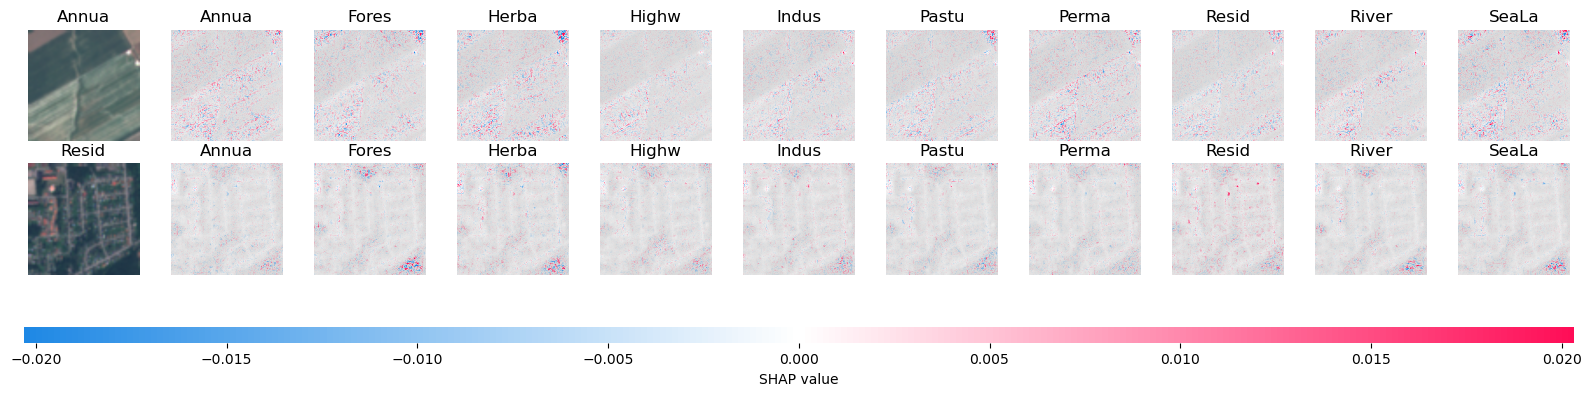

In [35]:
shap.image_plot(
    list(einops.rearrange(deep_shap_vals, "l b c h w -> l b h w c")),
    pixel_values=einops.rearrange((imgs_to_explain[:2] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=(np.tile([x[:5] for x in eurosat_val_ds.classes], (imgs_to_explain[:2].shape[0], 1))),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels[:2]],
    show=True,
)

In [36]:
pool_size = 16
pooled_deep_shap_vals = (pool_size ** 2) * nn.AvgPool2d(kernel_size=pool_size, stride=pool_size)(
    torch.from_numpy(deep_shap_vals).flatten(0, 1)).repeat_interleave(pool_size, dim=-2).repeat_interleave(pool_size,
                                                                                                           dim=-1)
pooled_deep_shap_vals = torch.unflatten(pooled_deep_shap_vals, 0, (len(eurosat_val_ds.classes), -1))

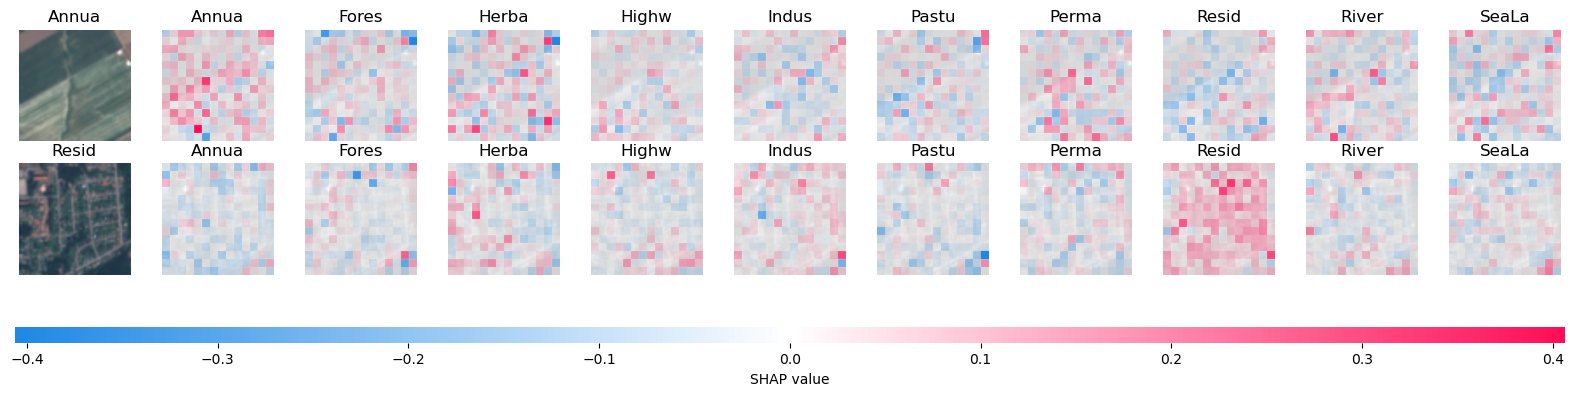

In [37]:
shap.image_plot(
    list(einops.rearrange(pooled_deep_shap_vals, "l b c h w -> l b h w c")),
    pixel_values=einops.rearrange((imgs_to_explain[:2] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=(np.tile([x[:5] for x in eurosat_val_ds.classes], (imgs_to_explain[:2].shape[0], 1))),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels[:2]],
    show=True,
)

###### Trying to debug the additivity of DeepExplainer...

In [43]:
class ResNet50Wrapper(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model
        self.activation = nn.Softmax(dim=-1)

    def forward(self, x):
        return self.activation(self.model(x))


wrapped_resnet50 = ResNet50Wrapper(resnet50)

In [47]:
e = shap.DeepExplainer((wrapped_resnet50, wrapped_resnet50.activation), random_bg_imgs[:50])
s = e.shap_values(imgs_to_explain[:2], check_additivity=True)

AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 0.8793167583795554 - Tolerance: 0.01

In [45]:
imgs_to_explain.min(), imgs_to_explain.max(), random_bg_imgs.min(), random_bg_imgs.max()

(tensor(-0.7895, device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(-0.8483, device='cuda:0'),
 tensor(1., device='cuda:0'))

In [48]:
# Use a simpler model for testing
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(16 * 224 * 224, len(eurosat_val_ds.classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


simple_model = SimpleModel().to(device)

e = shap.DeepExplainer(simple_model, random_bg_imgs[:50])
s = e.shap_values(imgs_to_explain[:2], check_additivity=True)

### Evaluate SHAP

#### Model Paramater Randomisation Check

In [43]:
def reset_child_params(model: nn.Module):
    """
    Reset all parameters of the model to their defaults inplace.
    Adapted from https://stackoverflow.com/questions/63627997/reset-parameters-of-a-neural-network-in-pytorch
    """
    for layer in model.children():
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()
        reset_child_params(layer)

In [44]:
randomised_model = copy.deepcopy(resnet50).to(device)
reset_child_params(randomised_model)

In [45]:
_, og_acc = helpers.ml.validation_step(
    resnet50, nn.CrossEntropyLoss(), validation_iterator, len(val_dataloader)
)
_, random_acc = helpers.ml.validation_step(
    randomised_model, nn.CrossEntropyLoss(), validation_iterator, len(val_dataloader)
)
print(f"Original/Randomised accuracy on validation set: {og_acc:.4f}/{random_acc:.4f}")

Validating:   0%|          | 0/169 [00:00<?, ?it/s]

Validating:   0%|          | 0/169 [00:00<?, ?it/s]

Original/Randomised accuracy on validation set: 0.9893/0.1008
